# BEVFormer++ Training Pipeline

A systematic training pipeline for the enhanced BEVFormer model with Memory Bank and ConvRNN.

## Table of Contents
1. Environment Setup & Configuration
2. Data Loading & Preprocessing
3. Model Architecture
4. Training Utilities
5. Training Loop
6. Evaluation & Visualization
7. Model Export & Inference

## 1. Environment Setup & Configuration

In [33]:
%load_ext autoreload
%autoreload 2

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os, sys, time, json
from datetime import datetime
from IPython.display import clear_output
from tqdm.notebook import tqdm

if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device: cuda
GPU: NVIDIA GeForce RTX 5070 Ti
Memory: 17.1 GB


In [34]:
# EXPERIMENT CONFIGURATION
# Optimized for RTX 5070 Ti 16GB VRAM
CONFIG = {
    'experiment_name': f'bevformer_{datetime.now().strftime("%Y%m%d_%H%M%S")}',
    'seed': SEED, 'data_root': 'data',
    'train_split': 0.7, 'val_split': 0.15, 'test_split': 0.15,
    'bev_h': 200, 'bev_w': 200, 'embed_dim': 256, 'num_classes': 10,
    # Increased training parameters for 16GB VRAM
    'batch_size': 2,              # Increased from 1 (safe for 16GB)
    'num_epochs': 30,             # Increased from 10 for better convergence
    'learning_rate': 4e-5,        # Slightly higher LR for larger batch
    'weight_decay': 1e-2,
    'grad_clip': 1.0,             # Tighter gradient clipping for stability
    'lr_scheduler': 'cosine',
    'warmup_epochs': 2,           # More warmup epochs
    'min_lr': 1e-7,
    'early_stopping': True,
    'patience': 8,                # More patience for longer training
    'checkpoint_dir': 'checkpoints',
    'save_every': 5,              # Save less frequently (every 5 epochs)
    # Mixed precision for memory efficiency
    'use_amp': True,              # Automatic Mixed Precision
}
os.makedirs(CONFIG['checkpoint_dir'], exist_ok=True)
with open(os.path.join(CONFIG['checkpoint_dir'], 'config.json'), 'w') as f:
    json.dump(CONFIG, f, indent=2)
print(json.dumps(CONFIG, indent=2))

{
  "experiment_name": "bevformer_20251213_182103",
  "seed": 42,
  "data_root": "data",
  "train_split": 0.7,
  "val_split": 0.15,
  "test_split": 0.15,
  "bev_h": 200,
  "bev_w": 200,
  "embed_dim": 256,
  "num_classes": 10,
  "batch_size": 2,
  "num_epochs": 30,
  "learning_rate": 4e-05,
  "weight_decay": 0.01,
  "grad_clip": 1.0,
  "lr_scheduler": "cosine",
  "warmup_epochs": 2,
  "min_lr": 1e-07,
  "early_stopping": true,
  "patience": 8,
  "checkpoint_dir": "checkpoints",
  "save_every": 5,
  "use_amp": true
}


## 2. Data Loading & Preprocessing

In [35]:
from modules.nuscenes_dataset import NuScenesDataset, collate_fn

print(f'Loading NuScenes from {CONFIG["data_root"]}...')
full_dataset = NuScenesDataset(dataroot=CONFIG['data_root'], version='v1.0-mini')

total_size = len(full_dataset)
train_size = int(CONFIG['train_split'] * total_size)
val_size = int(CONFIG['val_split'] * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(CONFIG['seed']))

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0, collate_fn=collate_fn)
print(f'Dataset: Train={train_size}, Val={val_size}, Test={test_size}')

Loading NuScenes from data...
Loaded 324 samples from nuScenes v1.0-mini (train)
Dataset: Train=226, Val=48, Test=50


## 3. Model Architecture

In [36]:
from modules.bevformer import EnhancedBEVFormer
from modules.head import BEVHead, DetectionLoss

model_backbone = EnhancedBEVFormer(bev_h=CONFIG['bev_h'], bev_w=CONFIG['bev_w'], embed_dim=CONFIG['embed_dim']).to(DEVICE)
model_head = BEVHead(embed_dim=CONFIG['embed_dim'], num_classes=CONFIG['num_classes']).to(DEVICE)
criterion = DetectionLoss()

total_params = sum(p.numel() for p in model_backbone.parameters()) + sum(p.numel() for p in model_head.parameters())
print(f'Total params: {total_params:,}')

Total params: 42,275,377


## 4. Training Utilities

In [37]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return self.early_stop

class MetricsTracker:
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.learning_rates = []
        self.best_val_loss = float('inf')
        self.best_epoch = 0
    
    def update(self, train_loss, val_loss, lr):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.learning_rates.append(lr)
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.best_epoch = len(self.val_losses)
            return True
        return False

def get_lr_scheduler(optimizer, config, num_training_steps):
    if config['lr_scheduler'] == 'cosine':
        return optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_training_steps, eta_min=config['min_lr'])
    elif config['lr_scheduler'] == 'step':
        return optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    return None

early_stopping = EarlyStopping(patience=CONFIG['patience']) if CONFIG['early_stopping'] else None
metrics = MetricsTracker()
print('Training utilities initialized')

Training utilities initialized


## 5. Training Loop

In [38]:
optimizer = optim.AdamW(list(model_backbone.parameters()) + list(model_head.parameters()),
                        lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
scheduler = get_lr_scheduler(optimizer, CONFIG, len(train_loader) * CONFIG['num_epochs'])

# Mixed Precision Scaler for memory efficiency and faster training
scaler = torch.amp.GradScaler('cuda') if CONFIG.get('use_amp', False) and torch.cuda.is_available() else None
use_amp = scaler is not None
print(f'Using AMP: {use_amp}')

def train_epoch(model_backbone, model_head, loader, optimizer, criterion, device, grad_clip, scaler=None, epoch=0):
    model_backbone.train()
    model_head.train()
    total_loss = 0
    H, W = CONFIG['bev_h'], CONFIG['bev_w']
    use_amp = scaler is not None
    
    pbar = tqdm(loader, desc=f'Epoch {epoch+1} Train', leave=False, 
                bar_format='{l_bar}{bar:20}{r_bar}{bar:-10b}')
    
    for batch in pbar:
        imgs = batch['img'].to(device)
        intrinsics = batch['intrinsics'].to(device)
        extrinsics = batch['extrinsics'].to(device)
        ego_pose = batch['ego_pose'].to(device)
        B = imgs.shape[0]
        targets = {'gt_cls': batch.get('gt_cls', torch.zeros(B, 10, H, W)).to(device),
                   'gt_bbox': batch.get('gt_bbox', torch.zeros(B, 7, H, W)).to(device),
                   'mask': batch.get('mask', torch.zeros(B, 1, H, W)).to(device)}
        
        optimizer.zero_grad()
        
        # Mixed precision forward pass
        with torch.amp.autocast('cuda', enabled=use_amp):
            bev_seq = model_backbone.forward_sequence(imgs, intrinsics, extrinsics, ego_pose)
            preds = model_head(bev_seq[:, -1])
            loss = criterion(preds, targets)['loss_total']
        
        # Backward pass with gradient scaling
        if scaler:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model_backbone.parameters(), grad_clip)
            torch.nn.utils.clip_grad_norm_(model_head.parameters(), grad_clip)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_backbone.parameters(), grad_clip)
            torch.nn.utils.clip_grad_norm_(model_head.parameters(), grad_clip)
            optimizer.step()
        
        if scheduler: scheduler.step()
        total_loss += loss.item()
        
        # Update progress bar with current loss
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'avg': f'{total_loss/(pbar.n+1):.4f}'})
    
    return total_loss / len(loader)

def validate(model_backbone, model_head, loader, criterion, device, desc='Val'):
    model_backbone.eval()
    model_head.eval()
    total_loss = 0
    H, W = CONFIG['bev_h'], CONFIG['bev_w']
    
    pbar = tqdm(loader, desc=f'       {desc}', leave=False,
                bar_format='{l_bar}{bar:20}{r_bar}{bar:-10b}')
    
    with torch.no_grad():
        for batch in pbar:
            imgs = batch['img'].to(device)
            intrinsics = batch['intrinsics'].to(device)
            extrinsics = batch['extrinsics'].to(device)
            ego_pose = batch['ego_pose'].to(device)
            B = imgs.shape[0]
            targets = {'gt_cls': batch.get('gt_cls', torch.zeros(B, 10, H, W)).to(device),
                       'gt_bbox': batch.get('gt_bbox', torch.zeros(B, 7, H, W)).to(device),
                       'mask': batch.get('mask', torch.zeros(B, 1, H, W)).to(device)}
            
            with torch.amp.autocast('cuda', enabled=use_amp):
                bev_seq = model_backbone.forward_sequence(imgs, intrinsics, extrinsics, ego_pose)
                preds = model_head(bev_seq[:, -1])
                loss = criterion(preds, targets)['loss_total'].item()
                total_loss += loss
            
            pbar.set_postfix({'loss': f'{loss:.4f}', 'avg': f'{total_loss/(pbar.n+1):.4f}'})
    
    return total_loss / len(loader)


Using AMP: True


Starting training for 30 epochs...
Batch size: 2, LR: 4e-05, AMP: True


Training:   0%|                              | 0/30 [00:00<?, ?it/s]

Epoch 1 Train:   0%|                    | 0/113 [00:00<?, ?it/s]

C:\Users\xiaot\AppData\Local\Temp\ipykernel_2460\3356534730.py:52: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  if scheduler: scheduler.step()


       Val:   0%|                    | 0/24 [00:00<?, ?it/s]

Epoch 01/30 | Train: 0.5211 | Val: 0.1359 | LR: 3.99e-05 | Time: 30.5s ★


Epoch 2 Train:   0%|                    | 0/113 [00:00<?, ?it/s]

       Val:   0%|                    | 0/24 [00:00<?, ?it/s]

Epoch 02/30 | Train: 0.0634 | Val: 0.0418 | LR: 3.96e-05 | Time: 29.7s ★


Epoch 3 Train:   0%|                    | 0/113 [00:00<?, ?it/s]

       Val:   0%|                    | 0/24 [00:00<?, ?it/s]

Epoch 03/30 | Train: 0.0179 | Val: 0.0282 | LR: 3.90e-05 | Time: 30.0s ★


Epoch 4 Train:   0%|                    | 0/113 [00:00<?, ?it/s]

       Val:   0%|                    | 0/24 [00:00<?, ?it/s]

Epoch 04/30 | Train: 0.0104 | Val: 0.0170 | LR: 3.83e-05 | Time: 29.6s ★


Epoch 5 Train:   0%|                    | 0/113 [00:00<?, ?it/s]

       Val:   0%|                    | 0/24 [00:00<?, ?it/s]

Epoch 05/30 | Train: 0.0068 | Val: 0.0177 | LR: 3.73e-05 | Time: 29.5s


Epoch 6 Train:   0%|                    | 0/113 [00:00<?, ?it/s]

       Val:   0%|                    | 0/24 [00:00<?, ?it/s]

Epoch 06/30 | Train: 0.0045 | Val: 0.0126 | LR: 3.62e-05 | Time: 29.9s ★


Epoch 7 Train:   0%|                    | 0/113 [00:00<?, ?it/s]

       Val:   0%|                    | 0/24 [00:00<?, ?it/s]

Epoch 07/30 | Train: 0.0037 | Val: 0.0103 | LR: 3.49e-05 | Time: 31.1s ★


Epoch 8 Train:   0%|                    | 0/113 [00:00<?, ?it/s]

       Val:   0%|                    | 0/24 [00:00<?, ?it/s]

Epoch 08/30 | Train: 0.0032 | Val: 0.0047 | LR: 3.34e-05 | Time: 30.0s ★


Epoch 9 Train:   0%|                    | 0/113 [00:00<?, ?it/s]

       Val:   0%|                    | 0/24 [00:00<?, ?it/s]

Epoch 09/30 | Train: 0.0025 | Val: 0.0064 | LR: 3.18e-05 | Time: 29.4s


Epoch 10 Train:   0%|                    | 0/113 [00:00<?, ?it/s]

       Val:   0%|                    | 0/24 [00:00<?, ?it/s]

Epoch 10/30 | Train: 0.0021 | Val: 0.0057 | LR: 3.00e-05 | Time: 30.1s


Epoch 11 Train:   0%|                    | 0/113 [00:00<?, ?it/s]

       Val:   0%|                    | 0/24 [00:00<?, ?it/s]

Epoch 11/30 | Train: 0.0018 | Val: 0.0054 | LR: 2.82e-05 | Time: 30.1s


Epoch 12 Train:   0%|                    | 0/113 [00:00<?, ?it/s]

       Val:   0%|                    | 0/24 [00:00<?, ?it/s]

Epoch 12/30 | Train: 0.0016 | Val: 0.0076 | LR: 2.62e-05 | Time: 29.2s


Epoch 13 Train:   0%|                    | 0/113 [00:00<?, ?it/s]

       Val:   0%|                    | 0/24 [00:00<?, ?it/s]

Epoch 13/30 | Train: 0.0015 | Val: 0.0032 | LR: 2.42e-05 | Time: 29.9s ★


Epoch 14 Train:   0%|                    | 0/113 [00:00<?, ?it/s]

       Val:   0%|                    | 0/24 [00:00<?, ?it/s]

Epoch 14/30 | Train: 0.0013 | Val: 0.0040 | LR: 2.21e-05 | Time: 29.0s


Epoch 15 Train:   0%|                    | 0/113 [00:00<?, ?it/s]

       Val:   0%|                    | 0/24 [00:00<?, ?it/s]

Epoch 15/30 | Train: 0.0012 | Val: 0.0051 | LR: 2.01e-05 | Time: 28.9s


Epoch 16 Train:   0%|                    | 0/113 [00:00<?, ?it/s]

       Val:   0%|                    | 0/24 [00:00<?, ?it/s]

Epoch 16/30 | Train: 0.0013 | Val: 0.0018 | LR: 1.80e-05 | Time: 29.8s ★


Epoch 17 Train:   0%|                    | 0/113 [00:00<?, ?it/s]

       Val:   0%|                    | 0/24 [00:00<?, ?it/s]

Epoch 17/30 | Train: 0.0010 | Val: 0.0030 | LR: 1.59e-05 | Time: 30.1s


Epoch 18 Train:   0%|                    | 0/113 [00:00<?, ?it/s]

       Val:   0%|                    | 0/24 [00:00<?, ?it/s]

Epoch 18/30 | Train: 0.0009 | Val: 0.0021 | LR: 1.39e-05 | Time: 29.8s


Epoch 19 Train:   0%|                    | 0/113 [00:00<?, ?it/s]

       Val:   0%|                    | 0/24 [00:00<?, ?it/s]

Epoch 19/30 | Train: 0.0009 | Val: 0.0023 | LR: 1.19e-05 | Time: 29.6s


Epoch 20 Train:   0%|                    | 0/113 [00:00<?, ?it/s]

       Val:   0%|                    | 0/24 [00:00<?, ?it/s]

Epoch 20/30 | Train: 0.0008 | Val: 0.0033 | LR: 1.01e-05 | Time: 29.2s


Epoch 21 Train:   0%|                    | 0/113 [00:00<?, ?it/s]

       Val:   0%|                    | 0/24 [00:00<?, ?it/s]

Epoch 21/30 | Train: 0.0009 | Val: 0.0031 | LR: 8.32e-06 | Time: 29.2s


Epoch 22 Train:   0%|                    | 0/113 [00:00<?, ?it/s]

       Val:   0%|                    | 0/24 [00:00<?, ?it/s]

Epoch 22/30 | Train: 0.0008 | Val: 0.0023 | LR: 6.70e-06 | Time: 29.3s


Epoch 23 Train:   0%|                    | 0/113 [00:00<?, ?it/s]

       Val:   0%|                    | 0/24 [00:00<?, ?it/s]

Epoch 23/30 | Train: 0.0008 | Val: 0.0027 | LR: 5.22e-06 | Time: 29.2s


Epoch 24 Train:   0%|                    | 0/113 [00:00<?, ?it/s]

       Val:   0%|                    | 0/24 [00:00<?, ?it/s]

Epoch 24/30 | Train: 0.0008 | Val: 0.0023 | LR: 3.91e-06 | Time: 29.2s
⚠️ Early stopping triggered at epoch 24
✅ Training complete! Best val loss: 0.0018 at epoch 16


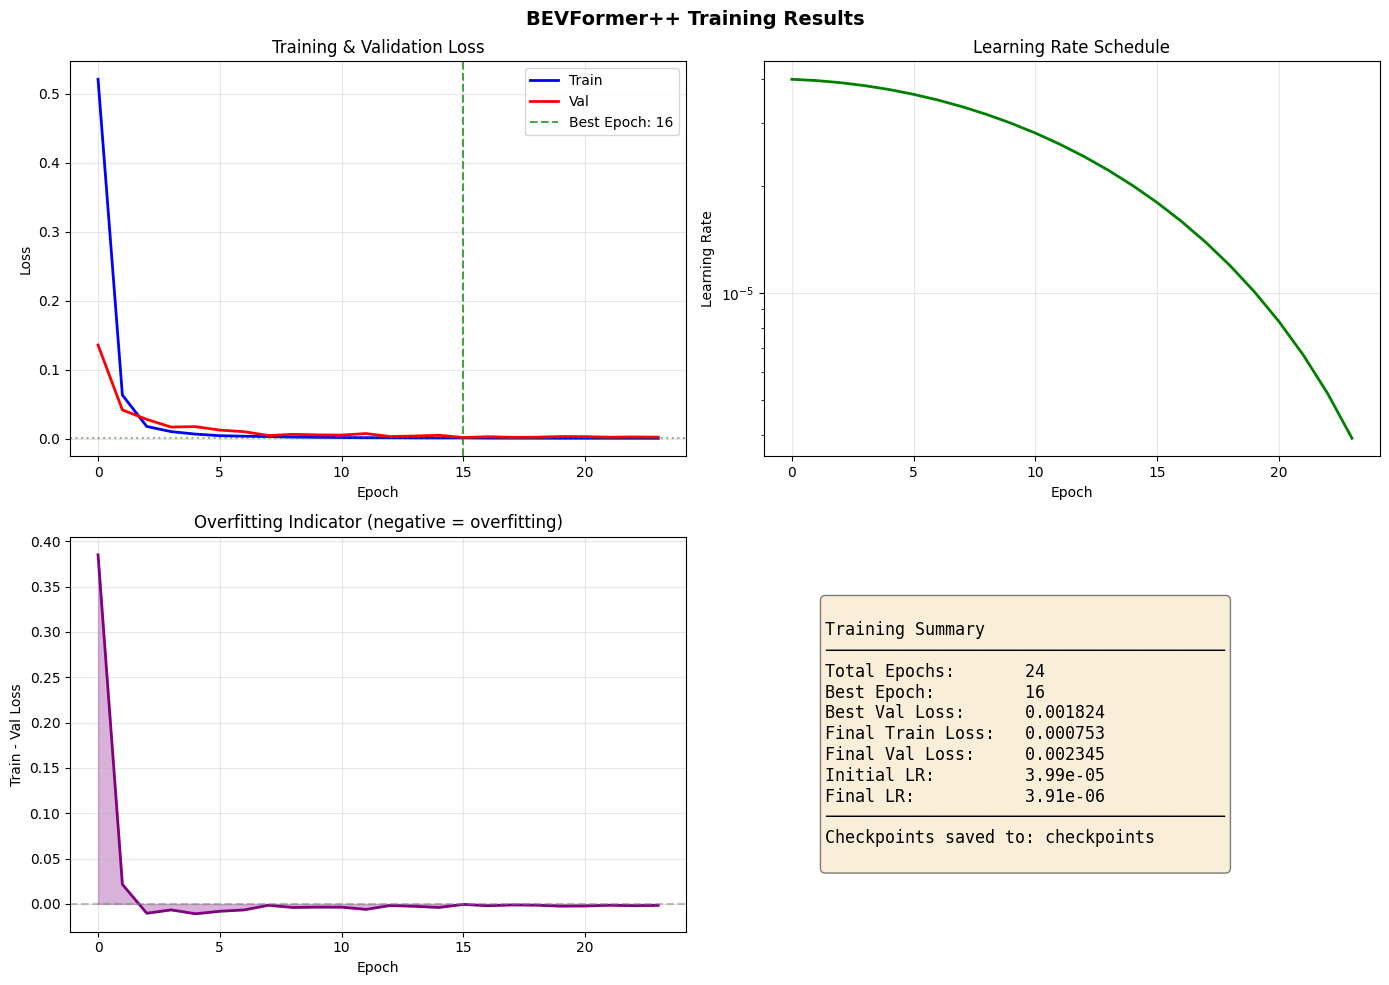

📊 Summary saved to checkpoints/training_summary.png


In [39]:
# Training Loop with Progress Bars
print(f'Starting training for {CONFIG["num_epochs"]} epochs...')
print(f'Batch size: {CONFIG["batch_size"]}, LR: {CONFIG["learning_rate"]}, AMP: {use_amp}')
print('=' * 80)

epoch_pbar = tqdm(range(CONFIG['num_epochs']), desc='Training', 
                  bar_format='{l_bar}{bar:30}{r_bar}')

for epoch in epoch_pbar:
    start_time = time.time()
    train_loss = train_epoch(model_backbone, model_head, train_loader, optimizer, criterion, 
                             DEVICE, CONFIG['grad_clip'], scaler, epoch)
    val_loss = validate(model_backbone, model_head, val_loader, criterion, DEVICE)
    lr = optimizer.param_groups[0]['lr']
    is_best = metrics.update(train_loss, val_loss, lr)
    elapsed = time.time() - start_time
    
    # Update epoch progress bar
    epoch_pbar.set_postfix({
        'train': f'{train_loss:.4f}', 
        'val': f'{val_loss:.4f}', 
        'best': f'{metrics.best_val_loss:.4f}',
        'lr': f'{lr:.1e}'
    })
    
    # Simple text summary per epoch
    best_marker = ' ★' if is_best else ''
    tqdm.write(f'Epoch {epoch+1:02d}/{CONFIG["num_epochs"]} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | LR: {lr:.2e} | Time: {elapsed:.1f}s{best_marker}')
    
    # Save checkpoint
    if is_best or (epoch + 1) % CONFIG['save_every'] == 0:
        ckpt_name = 'best.pth' if is_best else f'epoch_{epoch+1}.pth'
        torch.save({'backbone_state_dict': model_backbone.state_dict(),
                    'head_state_dict': model_head.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'epoch': epoch + 1, 'val_loss': val_loss},
                   os.path.join(CONFIG['checkpoint_dir'], ckpt_name))
    
    if early_stopping and early_stopping(val_loss):
        tqdm.write(f'⚠️ Early stopping triggered at epoch {epoch+1}')
        break

# Save final checkpoint
torch.save({'backbone_state_dict': model_backbone.state_dict(), 'head_state_dict': model_head.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scaler_state_dict': scaler.state_dict() if scaler else None}, 
           os.path.join(CONFIG['checkpoint_dir'], 'latest.pth'))

print('=' * 80)
print(f'✅ Training complete! Best val loss: {metrics.best_val_loss:.4f} at epoch {metrics.best_epoch}')

# Comprehensive visualization after training
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss curves
axes[0, 0].plot(metrics.train_losses, 'b-', label='Train', linewidth=2)
axes[0, 0].plot(metrics.val_losses, 'r-', label='Val', linewidth=2)
axes[0, 0].axvline(metrics.best_epoch - 1, color='g', linestyle='--', alpha=0.7, label=f'Best Epoch: {metrics.best_epoch}')
axes[0, 0].axhline(metrics.best_val_loss, color='g', linestyle=':', alpha=0.5)
axes[0, 0].set_xlabel('Epoch'); axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training & Validation Loss'); axes[0, 0].legend(); axes[0, 0].grid(True, alpha=0.3)

# Learning rate schedule
axes[0, 1].plot(metrics.learning_rates, 'g-', linewidth=2)
axes[0, 1].set_xlabel('Epoch'); axes[0, 1].set_ylabel('Learning Rate')
axes[0, 1].set_title('Learning Rate Schedule'); axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_yscale('log')

# Loss difference (overfitting indicator)
loss_diff = [t - v for t, v in zip(metrics.train_losses, metrics.val_losses)]
axes[1, 0].plot(loss_diff, 'purple', linewidth=2)
axes[1, 0].axhline(0, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].fill_between(range(len(loss_diff)), loss_diff, 0, alpha=0.3, color='purple')
axes[1, 0].set_xlabel('Epoch'); axes[1, 0].set_ylabel('Train - Val Loss')
axes[1, 0].set_title('Overfitting Indicator (negative = overfitting)'); axes[1, 0].grid(True, alpha=0.3)

# Training summary stats
ax = axes[1, 1]
ax.axis('off')
summary_text = f"""
Training Summary
{'─' * 40}
Total Epochs:       {len(metrics.train_losses)}
Best Epoch:         {metrics.best_epoch}
Best Val Loss:      {metrics.best_val_loss:.6f}
Final Train Loss:   {metrics.train_losses[-1]:.6f}
Final Val Loss:     {metrics.val_losses[-1]:.6f}
Initial LR:         {metrics.learning_rates[0]:.2e}
Final LR:           {metrics.learning_rates[-1]:.2e}
{'─' * 40}
Checkpoints saved to: {CONFIG['checkpoint_dir']}
"""
ax.text(0.1, 0.5, summary_text, transform=ax.transAxes, fontsize=12, 
        verticalalignment='center', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('BEVFormer++ Training Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['checkpoint_dir'], 'training_summary.png'), dpi=150, bbox_inches='tight')
plt.show()
print(f'📊 Summary saved to {CONFIG["checkpoint_dir"]}/training_summary.png')

## 6. Evaluation & Visualization

Evaluating on test set...


       Val:   0%|                    | 0/25 [00:00<?, ?it/s]

Test Loss: 0.0021


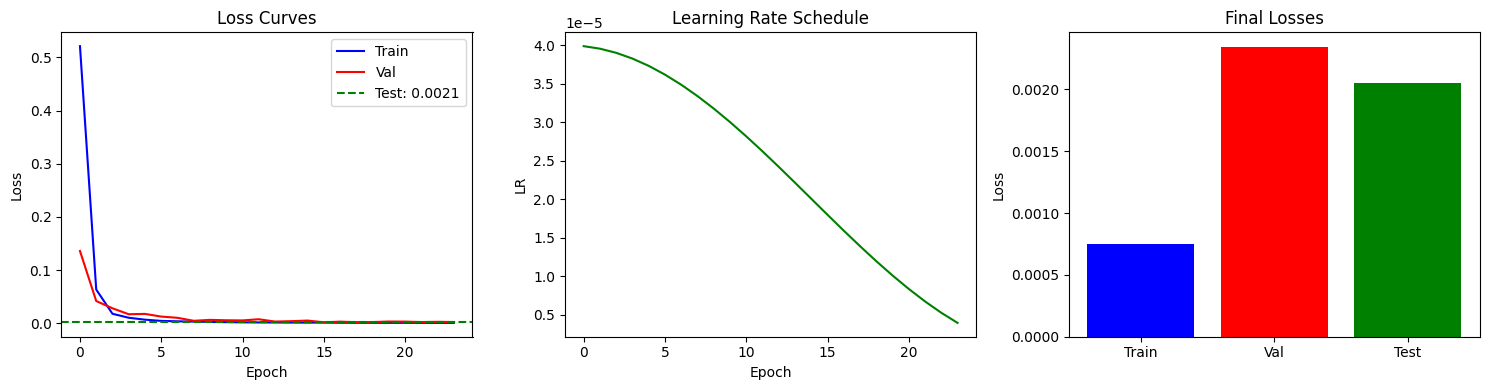

Summary saved to checkpoints/training_summary.png


In [40]:
# Test Set Evaluation
print('Evaluating on test set...')
test_loss = validate(model_backbone, model_head, test_loader, criterion, DEVICE)
print(f'Test Loss: {test_loss:.4f}')

# Final Training Summary
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].plot(metrics.train_losses, 'b-', label='Train')
axes[0].plot(metrics.val_losses, 'r-', label='Val')
axes[0].axhline(test_loss, color='g', linestyle='--', label=f'Test: {test_loss:.4f}')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss'); axes[0].legend(); axes[0].set_title('Loss Curves')
axes[1].plot(metrics.learning_rates, 'g-')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('LR'); axes[1].set_title('Learning Rate Schedule')
axes[2].bar(['Train', 'Val', 'Test'], [metrics.train_losses[-1], metrics.val_losses[-1], test_loss], color=['blue', 'red', 'green'])
axes[2].set_ylabel('Loss'); axes[2].set_title('Final Losses')
plt.tight_layout(); plt.savefig(os.path.join(CONFIG['checkpoint_dir'], 'training_summary.png'), dpi=150)
plt.show()
print(f'Summary saved to {CONFIG["checkpoint_dir"]}/training_summary.png')

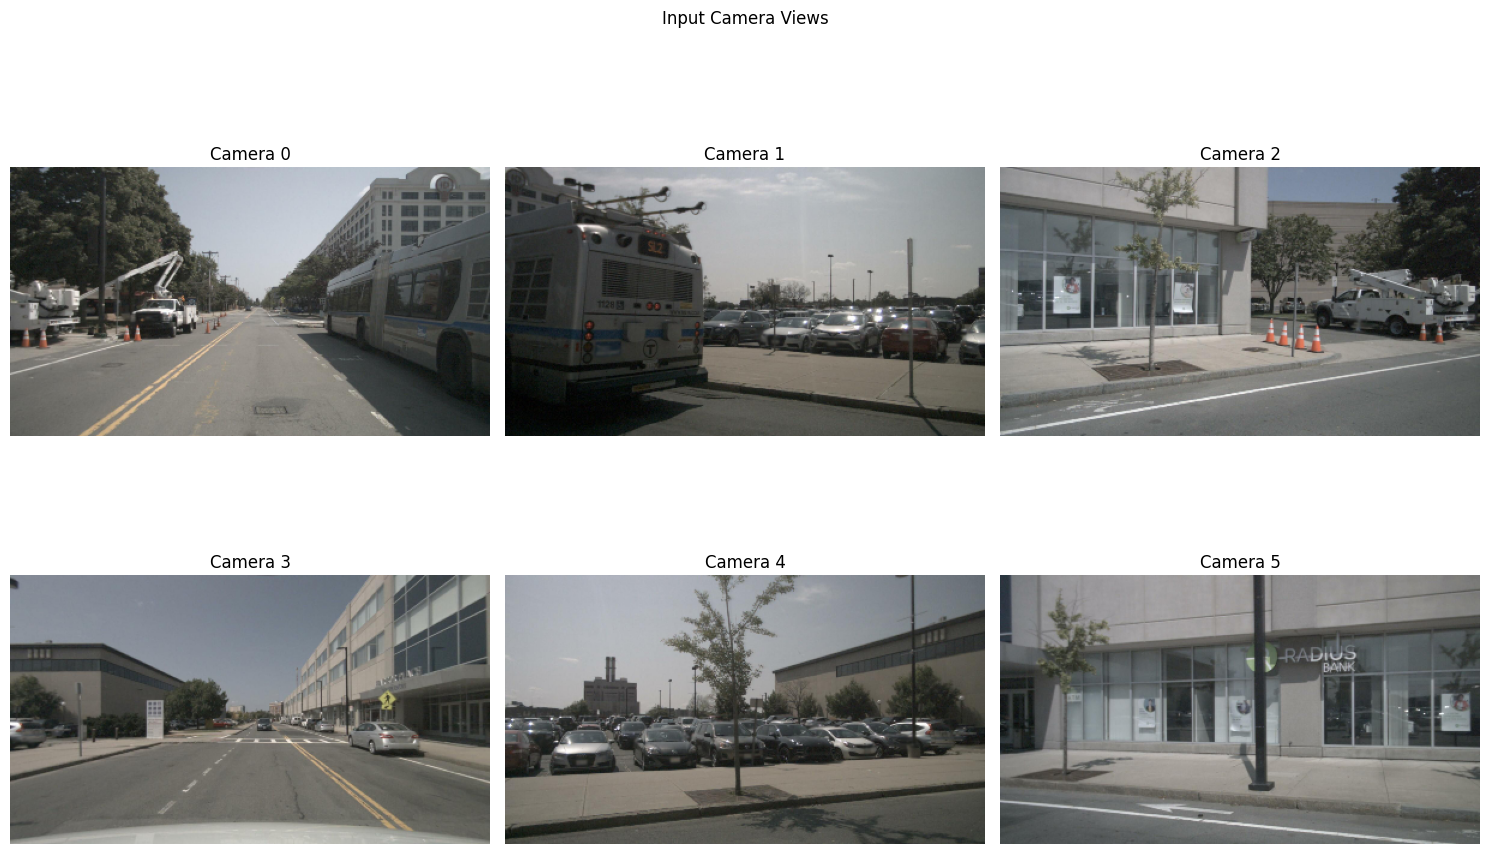

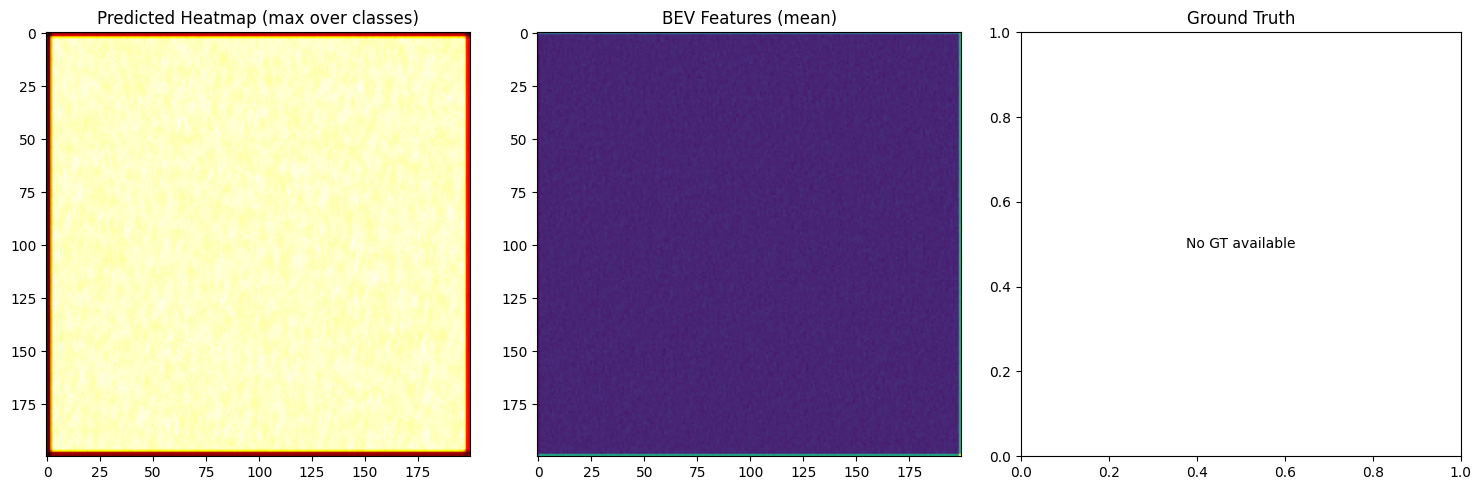

In [41]:
# Visualize Sample Predictions
model_backbone.eval()
model_head.eval()

sample_batch = next(iter(test_loader))
with torch.no_grad():
    imgs = sample_batch['img'].to(DEVICE)
    intrinsics = sample_batch['intrinsics'].to(DEVICE)
    extrinsics = sample_batch['extrinsics'].to(DEVICE)
    ego_pose = sample_batch['ego_pose'].to(DEVICE)
    bev_seq = model_backbone.forward_sequence(imgs, intrinsics, extrinsics, ego_pose)
    preds = model_head(bev_seq[:, -1])

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# Show input cameras (last frame)
for i in range(min(6, imgs.shape[2])):
    ax = axes[i // 3, i % 3]
    img = imgs[0, -1, i].cpu().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(f'Camera {i}')
    ax.axis('off')
plt.suptitle('Input Camera Views')
plt.tight_layout(); plt.show()

# Show BEV predictions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
cls_pred = preds['cls_score'][0].cpu().numpy()
axes[0].imshow(cls_pred.max(axis=0), cmap='hot')
axes[0].set_title('Predicted Heatmap (max over classes)')
axes[1].imshow(bev_seq[0, -1].mean(dim=0).cpu().numpy(), cmap='viridis')
axes[1].set_title('BEV Features (mean)')
if 'gt_cls' in sample_batch:
    axes[2].imshow(sample_batch['gt_cls'][0].max(dim=0)[0].numpy(), cmap='hot')
    axes[2].set_title('Ground Truth Heatmap')
else:
    axes[2].text(0.5, 0.5, 'No GT available', ha='center', va='center', transform=axes[2].transAxes)
    axes[2].set_title('Ground Truth')
plt.tight_layout(); plt.show()

## 7. Model Export & Inference

In [42]:
def load_best_model(checkpoint_dir, device):
    """Load the best model checkpoint for inference."""
    best_path = os.path.join(checkpoint_dir, 'best.pth')
    if not os.path.exists(best_path):
        best_path = os.path.join(checkpoint_dir, 'latest.pth')
    
    backbone = EnhancedBEVFormer(bev_h=CONFIG['bev_h'], bev_w=CONFIG['bev_w'], embed_dim=CONFIG['embed_dim']).to(device)
    head = BEVHead(embed_dim=CONFIG['embed_dim'], num_classes=CONFIG['num_classes']).to(device)
    
    ckpt = torch.load(best_path, map_location=device, weights_only=True)
    # Filter mismatched keys
    bb_state = ckpt['backbone_state_dict']
    bb_model = backbone.state_dict()
    bb_filtered = {k: v for k, v in bb_state.items() if k in bb_model and v.shape == bb_model[k].shape}
    backbone.load_state_dict(bb_filtered, strict=False)
    hd_state = ckpt['head_state_dict']
    hd_model = head.state_dict()
    hd_filtered = {k: v for k, v in hd_state.items() if k in hd_model and v.shape == hd_model[k].shape}
    head.load_state_dict(hd_filtered, strict=False)
    backbone.eval()
    head.eval()
    print(f'Loaded model from {best_path}')
    return backbone, head

# Load best model
best_backbone, best_head = load_best_model(CONFIG['checkpoint_dir'], DEVICE)
print('Best model ready for inference!')

Loaded model from checkpoints\best.pth
Best model ready for inference!


In [43]:
# Inference Example
def run_inference(backbone, head, batch, device):
    """Run inference on a single batch."""
    backbone.eval()
    head.eval()
    with torch.no_grad():
        imgs = batch['img'].to(device)
        intrinsics = batch['intrinsics'].to(device)
        extrinsics = batch['extrinsics'].to(device)
        ego_pose = batch['ego_pose'].to(device)
        bev_features = backbone.forward_sequence(imgs, intrinsics, extrinsics, ego_pose)
        predictions = head(bev_features[:, -1])
    return predictions

# Test inference
sample = next(iter(test_loader))
preds = run_inference(best_backbone, best_head, sample, DEVICE)
print(f'Inference output shapes:')
print(f'  cls_score: {preds["cls_score"].shape}')
print(f'  bbox_pred: {preds["bbox_pred"].shape}')
print('\nModel is ready for deployment!')

Inference output shapes:
  cls_score: torch.Size([2, 10, 200, 200])
  bbox_pred: torch.Size([2, 7, 200, 200])

Model is ready for deployment!
